## 1. Sujet 4 : Secteurs data mining US

#### Consignes :
le but de ce projet est de quantifier la relation entre les performances boursières et les données fondamentales
pour chaque question on donnera une structure adéquate aux données pour faciliter les traitements de calcul

quel est le coefficient de corrélation de chaque donnée fondamentale avec les performances ?
a l'aide d'outils adéquats (ACP, AFD, regression linéaire…), mettre en évidence l'impact des données fondamentales sur les performances des indices sectoriels
y a-t-il des spécificités sectorielles ou de thème d'investissement qui se dégagent ?
y a-t-il des années ou les données fondamentales prédisent mieux les performances et pour quels secteurs?
proposer une méthode de scoring pour sélectionner les secteurs ou investir en début de chaque année
proposer des pistes d'amélioration de la méthode


#### Méthodes utilisées :
- Table de corrélation
- Analyse en Composante Principale (ACP)
- Régression linéaire

## 2. Importer Les données préalablement préparées dans Excel
#### Modification apportées :
- Simplifier des noms des lignes et colonnes
- Ajouter la colonne date 
    - Retirer un an pour les lignes "% YTD Change"
- Remplacer " " par "" pour une meilleure identification des valeurs manquantes dans le jeu de données

In [13]:
import os
import pandas as pd

In [14]:
df = pd.read_csv(os.getcwd()+"/Dataset.csv", index_col="Metrics")
df.head().round(3)

,Date,Energy,Utilities,Materials,Financials,Industrials,Health Care,Real Estate,Consumer Staples
Metrics,,,,,,,,,
% Change YTD,31/12/2017,-0.165,0.055,-0.122,-0.104,-0.107,0.100,-0.009,-0.067
EPS NTMA Growth 1 year,31/12/2017,35.724,5.282,19.394,15.715,9.252,6.463,6.637,7.676
Price to Earnings,31/12/2017,25.509,17.815,17.997,14.761,19.566,16.687,18.006,20.546
Price to Book Value,31/12/2017,1.977,1.906,2.711,1.493,4.811,3.627,3.362,5.127
Price to Cash Flow,31/12/2017,9.262,7.350,11.406,NaN,13.511,14.052,17.885,15.666


- Sélectioner le secteur à analyser
- Pivoter le dataset pour faciliter l'analyse des données sur le secteur étudié

In [15]:
sector = 'Energy'

# Sélection du secteur et de la colonne "Date"
dataset = df[[sector, 'Date']]

# Réorganisation des données : pivotage et suppression des valeurs manquantes
dataset = dataset.reset_index().pivot(index='Metrics', columns='Date').dropna()

# Supression de la dimension secteur et transposition des axes
dataset = dataset[sector].transpose()
dataset.head().round(3)

Metrics,% Change YTD,Assets/Equity,Dividend Payout,Dividend Yield,EBIT Margin,EBITDA Margin,EPS NTMA Growth 1 year,Enterprise Value to EBIT,Enterprise Value to EBITDA,Enterprise Value to Sales,Net Debt/EBITDA,PEG,Price to Book Value,Price to Cash Flow,Price to Earnings,Price to Free Cash Flow,Price to Sales,Return on Equity
Date,,,,,,,,,,,,,,,,,,
31/12/2008,0.078,1.957,26.066,2.529,13.021,19.674,-31.612,7.294,4.828,0.950,0.296,1.304,1.584,5.946,10.311,22.029,0.918,15.361
31/12/2009,0.261,1.831,28.447,2.383,14.212,19.612,50.138,6.576,4.765,0.935,0.307,1.453,1.803,6.334,11.936,29.494,0.857,15.102
31/12/2010,0.062,1.846,25.761,2.133,13.793,19.574,12.988,7.427,5.233,1.024,0.316,1.256,1.839,6.664,12.077,33.076,0.962,15.228
31/12/2011,0.008,1.839,22.066,2.244,15.194,20.516,0.733,6.076,4.500,0.923,0.272,0.869,1.699,5.904,9.835,24.308,0.862,17.276
31/12/2012,0.170,1.896,27.427,2.590,14.459,19.841,3.583,6.538,4.765,0.945,0.415,2.688,1.598,5.989,10.590,30.489,0.854,15.090


## 3. Table de corrélation de l'évolution au cours des années des valeurs fondamentales du secteur sélectionné

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

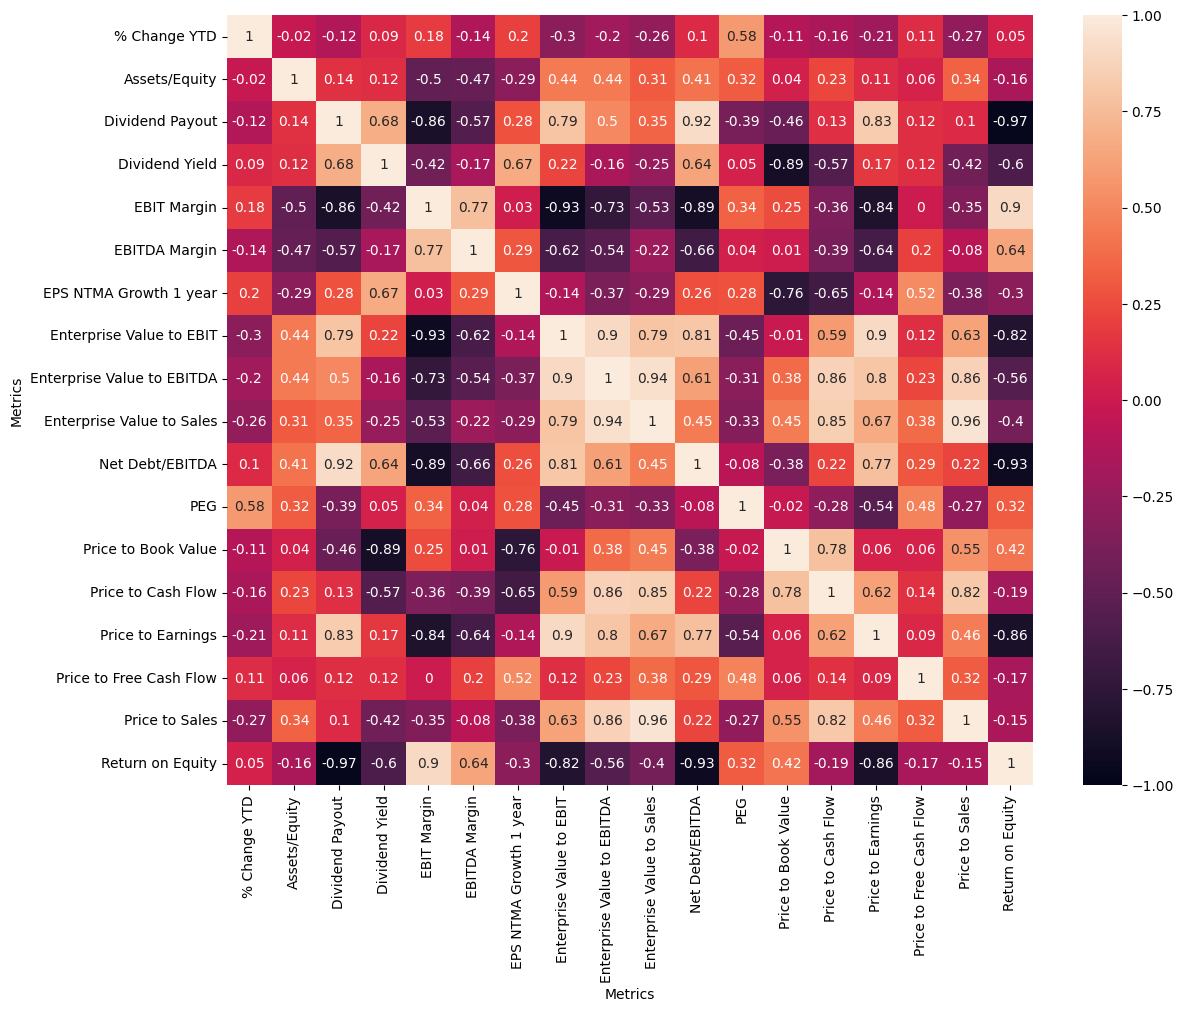

In [17]:
# Calcul des variations en pourcentage
dataset_pct_change = dataset.pct_change()

# Ajustement de la taille de la figure
plt.gcf().set_size_inches(13, 10)

# Affichage de la heatmap de corrélation
sns.heatmap(dataset_pct_change.corr().round(2), vmin=-1, vmax=1, annot=True)
plt.show()

### Commentaires sur la table de correlation par secteur
- Energy
- Utilities
- Materials
- Financials
- Industrials
- Health Care
- Real Estate
- Consumer staples

## 4. ACP sur le jeu de données préparé

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets
from IPython.display import display, clear_output

In [19]:
class MyPCA:
    def __init__(self, data):
        self.features_list = data.columns
        # Normalisation des données
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        self.data = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)

        # Application de l'ACP
        self.pca = PCA()
        data_pca = self.pca.fit_transform(self.data)
        self.data_pca = pd.DataFrame(data_pca, columns=[f'PC{x}' for x in range(1, data_pca.shape[1]+1)])

    def component_correlations(self):
        correlations = self.pca.components_.T * np.sqrt(self.pca.explained_variance_) / self.data.std(axis=0).values.reshape(-1, 1)
        table = pd.DataFrame(
            correlations,
            index=self.features_list,
            columns = self.data_pca.columns
        )
        return table

    def eigenval_plot(self):
        plt.figure(figsize=(8, 5))
        
        # Barres des pourcentages d'inertie
        bars = plt.bar(range(1, len(self.pca.explained_variance_ratio_) + 1), 
                    self.pca.explained_variance_ratio_, 
                    color='blue', alpha=0.7)
        
        # Ajout des valeurs propres (eigenvalues) au-dessus des barres
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, 
                    f'{self.pca.explained_variance_ratio_[i]:.2f}', 
                    ha='center', va='bottom', fontsize=9)
        
        # Labels et titre
        plt.xlabel("Factors")
        plt.ylabel("Percentage of Inertia")
        plt.title("Eigenvalues histogram")
        plt.xticks(np.arange(1, len(self.pca.explained_variance_ratio_) + 1, step=1))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def var_plot(self):
        # Conteneur d'affichage
        output = widgets.Output()

        # Fonction de mise à jour du graphique
        def update_plot(*_):
            with output:
                clear_output(wait=True)
                pc_x, pc_y = pc_x_widget.value - 1, pc_y_widget.value - 1
                fig, ax = plt.subplots(figsize=(fig_size_widget.value, fig_size_widget.value))

                # Dégradé de couleur selon une colonne spécifique
                color_column = point_color_widget.value
                if color_column is not None:
                    color_values = self.data[color_column]
                    norm = plt.Normalize(color_values.min(), color_values.max())
                else:
                    color_values = None
                    norm = None

                # Ajouter les points colorés en fonction de la valeur dans color_column
                if show_point_widget.value:
                    if color_values is not None:
                        scatter = ax.scatter(
                            self.data_pca.iloc[:, pc_x], self.data_pca.iloc[:, pc_y],
                            c=color_values, cmap='RdBu', norm=norm, edgecolors='k', s=75
                        )
                        cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)  # Réduire la taille de la barre de couleur
                        cbar.ax.tick_params(labelsize=6, width=0.1)
                        cbar.set_label(color_column, fontsize=9)
                    else:
                        ax.scatter(self.data_pca.iloc[:, pc_x], self.data_pca.iloc[:, pc_y], color='blue', edgecolors='k', alpha=0.7, s=75)

                    if show_point_labels_widget.value:
                        for i, txt in enumerate(self.data.index):
                            x, y = self.data_pca.iloc[i, pc_x], self.data_pca.iloc[i, pc_y]
                            ax.text(x, y, txt, fontsize=9, ha='right')

                # Cercle unité
                ax.add_artist(plt.Circle((0, 0), 1, color='gray', linestyle='--', fill=False))

                # Flèches des variables
                correlations = self.pca.components_.T * np.sqrt(self.pca.explained_variance_) / self.data.std(axis=0).values.reshape(-1, 1)
                if show_all_vectors_widget.value:
                    for i in range(correlations.shape[0]):
                        x, y = correlations[i, pc_x], correlations[i, pc_y]
                        # Par défaut, tous les vecteurs sont rouges
                        vector_color = 'red'
                        # Si un vecteur est sélectionné, on le colore en vert
                        if self.features_list[i] == vector_color_widget.value:
                            vector_color = 'green'
                        plt.arrow(0, 0, x, y, color=vector_color, alpha=0.7, head_width=0.02, head_length=0.02)
                        if show_vector_labels_widget.value:
                            plt.text(x, y, self.features_list[i], fontsize=10, ha='center', va='center')

                # Ajustements visuels pour se focaliser sur [-axis_limit, axis_limit]
                ax.set_xlim(-axis_limit_widget.value, axis_limit_widget.value)
                ax.set_ylim(-axis_limit_widget.value, axis_limit_widget.value)
                ax.set_xlabel(f'PC{pc_x + 1}')
                ax.set_ylabel(f'PC{pc_y + 1}')
                ax.set_title('Variable plots (PCA)')
                ax.set_aspect('equal')
                plt.axhline(0, color='grey', linestyle='--')
                plt.axvline(0, color='grey', linestyle='--')
                plt.grid(False)
                plt.show()

        # Widgets pour sélectionner les composantes principales
        pc_x_widget = widgets.IntSlider(value=1, min=1, max=self.pca.n_components_, description='PC X:')
        pc_y_widget = widgets.IntSlider(value=2, min=1, max=self.pca.n_components_, description='PC Y:')

        # Section 1 : Sélection des composantes principales
        pc_selection_label = widgets.Label(value="Principal Components Selection")
        pc_selection = widgets.VBox([pc_selection_label, pc_x_widget, pc_y_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Widgets pour les points
        show_point_widget = widgets.Checkbox(value=False, description='Show points')
        show_point_labels_widget = widgets.Checkbox(value=False, description='Show point labels')
        point_color_widget = widgets.Dropdown(
            options=[("None", None)] + [(col, col) for col in self.features_list],
            value=None,
            description='Point color:'
        )

        # Section 2 : Options d'affichage des points
        point_options_label = widgets.Label(value="Point Display Options")
        point_options = widgets.VBox([point_options_label, show_point_widget, show_point_labels_widget, point_color_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Widgets pour les vecteurs
        show_all_vectors_widget = widgets.Checkbox(value=True, description='Show vectors')
        show_vector_labels_widget = widgets.Checkbox(value=False, description='Show vector labels')
        vector_color_widget = widgets.Dropdown(
            options=[("None", None)] + [(col, col) for col in self.features_list],
            value=None,
            description='Vector color:'
        )

        # Section 3 : Options d'affichage des vecteurs
        vector_options_label = widgets.Label(value="Vector Display Options")
        vector_options = widgets.VBox([vector_options_label, show_all_vectors_widget, show_vector_labels_widget, vector_color_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Widgets pour les paramètres généraux
        fig_size_widget = widgets.IntSlider(value=10, min=8, max=14, description='Figure length')
        axis_limit_widget = widgets.IntSlider(value=2, min=1, max=20, description='Axis limit')

        # Section 4 : Paramètres généraux
        general_options_label = widgets.Label(value="General Settings")
        general_options = widgets.VBox([general_options_label, fig_size_widget, axis_limit_widget], layout=widgets.Layout(border='1px solid gray', padding='10px', margin='5px'))

        # Liaison des widgets
        for widget in [pc_x_widget, pc_y_widget, show_point_widget, show_point_labels_widget, show_all_vectors_widget,
                    show_vector_labels_widget, fig_size_widget, axis_limit_widget, point_color_widget, vector_color_widget]:
            widget.observe(update_plot, names='value')

        # Affichage des sections
        display(widgets.VBox([pc_selection, point_options, vector_options, general_options]), output)
        update_plot()

In [20]:
mypca = MyPCA(dataset)

In [21]:
mypca.component_correlations().round(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Metrics,,,,,,,,,,
% Change YTD,-0.458,-0.608,-0.541,-0.137,0.268,0.080,0.157,0.076,-0.012,0.0
Assets/Equity,0.838,-0.043,0.238,0.450,-0.142,0.069,0.012,0.109,0.017,0.0
Dividend Payout,0.953,-0.267,-0.098,-0.083,0.010,0.041,-0.023,-0.034,0.011,0.0
Dividend Yield,0.664,-0.715,0.108,0.093,-0.045,0.072,0.111,-0.064,0.054,-0.0
EBIT Margin,-0.966,0.165,0.118,-0.097,0.079,0.084,0.021,-0.035,-0.032,0.0
EBITDA Margin,-0.522,-0.021,0.711,-0.405,-0.087,0.222,0.010,0.031,0.015,-0.0
EPS NTMA Growth 1 year,0.610,0.596,-0.365,0.051,0.277,0.214,-0.119,0.013,0.022,-0.0
Enterprise Value to EBIT,0.994,0.003,-0.073,-0.049,-0.037,0.029,-0.034,0.001,-0.004,-0.0
Enterprise Value to EBITDA,0.993,0.079,0.027,-0.078,-0.022,-0.005,0.019,0.001,-0.026,0.0


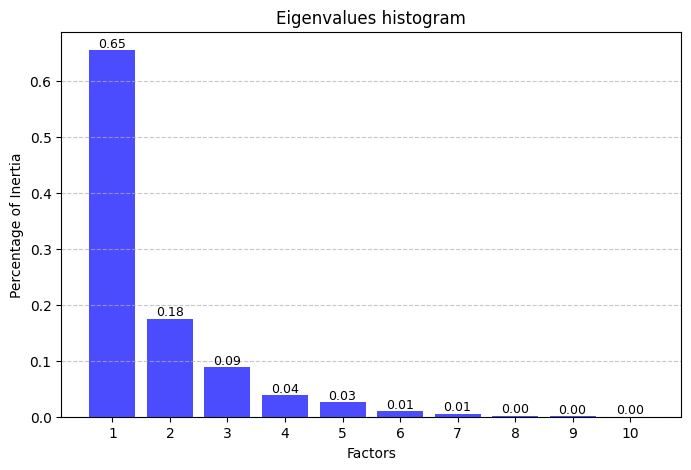

In [22]:
mypca.eigenval_plot()

In [23]:
mypca.var_plot()

Output()

#### Commentaires sur les résultats de l'ACP par secteur :
- Energy
- Utilities
- Materials
- Financials
- Industrials
- Health Care
- Real Estate
- Consumer staples

## 5. Régression linéaire sur le jeu de données préparé
- variables indépendantes : données fondamentales en t
- variables dépendante : % Change YTD en t+1

In [24]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [26]:
dataset

Metrics,% Change YTD,Assets/Equity,Dividend Payout,Dividend Yield,EBIT Margin,EBITDA Margin,EPS NTMA Growth 1 year,Enterprise Value to EBIT,Enterprise Value to EBITDA,Enterprise Value to Sales,Net Debt/EBITDA,PEG,Price to Book Value,Price to Cash Flow,Price to Earnings,Price to Free Cash Flow,Price to Sales,Return on Equity
Date,,,,,,,,,,,,,,,,,,
31/12/2008,0.078181,1.957385,26.066299,2.528743,13.021090,19.673923,-31.612384,7.294195,4.827627,0.949784,0.295532,1.303937,1.583926,5.945802,10.311354,22.028709,0.917629,15.360986
31/12/2009,0.260505,1.830921,28.446848,2.383306,14.211521,19.612182,50.138475,6.576025,4.765167,0.934553,0.306667,1.452766,1.802609,6.333890,11.935877,29.493667,0.856763,15.102442
31/12/2010,0.062095,1.845681,25.760721,2.133104,13.792927,19.574255,12.987630,7.426849,5.233302,1.024380,0.316385,1.255827,1.839004,6.664309,12.076636,33.076046,0.962401,15.227783
31/12/2011,0.007630,1.839091,22.066181,2.243754,15.193670,20.515691,0.733161,6.076408,4.500114,0.923229,0.272453,0.869499,1.699044,5.904350,9.834503,24.308127,0.861995,17.276320
31/12/2012,0.169881,1.896035,27.427292,2.589911,14.459438,19.840843,3.583265,6.538425,4.765017,0.945420,0.415340,2.687596,1.598048,5.989163,10.590053,30.488776,0.854105,15.090082
31/12/2013,0.025038,1.892694,31.616169,2.430979,14.595439,20.935968,10.300688,8.247120,5.749452,1.203703,0.535301,1.504674,1.871437,7.043648,13.013372,61.999919,1.081408,14.380875
31/12/2014,-0.148425,2.042671,51.312943,3.060346,11.444082,20.009172,-18.590830,11.690819,6.686468,1.337907,0.908776,2.075859,1.752269,7.384171,16.780951,87.766885,1.150596,10.442011
31/12/2015,0.273493,1.979737,98.819220,3.689865,8.662263,19.390217,-4.565901,17.687377,7.901547,1.532127,1.529580,-6.582237,1.522462,7.971999,26.781260,61.192201,1.236330,5.684802
31/12/2016,-0.155041,2.055160,86.538241,2.653367,8.402379,18.822386,292.067764,21.640629,9.548664,1.796940,1.523056,4.375005,2.063480,10.034947,32.613259,29.896030,1.468396,6.364857


In [38]:
# Standardisation des variables explicatives
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(dataset)

# Séparation de la variable cible (y) et des variables explicatives (X)
y = scaled_dataset[:,0]
X = scaled_dataset[:,1:]

# Entraînement du modèle de régression linéaire
reg = LinearRegression().fit(X, y)

# Calcul et affichage du score R2
r2_score = reg.score(X, y)
print(f"Score R2 : {r2_score:.2f}")

Score R2 : 1.00


In [40]:
# Extraction des coefficients de la régression et création d'une Series
X_coef = pd.Series(reg.coef_, index=dataset.columns[1:])

# Tri des coefficients par ordre décroissant
X_coef_sorted = X_coef.sort_values(ascending=False)
print(X_coef_sorted)

Metrics
Price to Sales                1.959379
EBIT Margin                   1.926485
EPS NTMA Growth 1 year        1.751925
Dividend Yield                1.651989
Price to Cash Flow            1.008501
Enterprise Value to Sales     0.183202
Enterprise Value to EBITDA   -0.189889
Assets/Equity                -0.210294
Price to Free Cash Flow      -0.349989
EBITDA Margin                -0.602842
Price to Book Value          -0.645489
Price to Earnings            -0.969106
Dividend Payout              -1.060659
PEG                          -1.199329
Net Debt/EBITDA              -1.889837
Enterprise Value to EBIT     -1.969512
Return on Equity             -2.277203
dtype: float64


#### Affichage à titre d'illustration des valeurs prédites par le modèle et des valeurs réelles

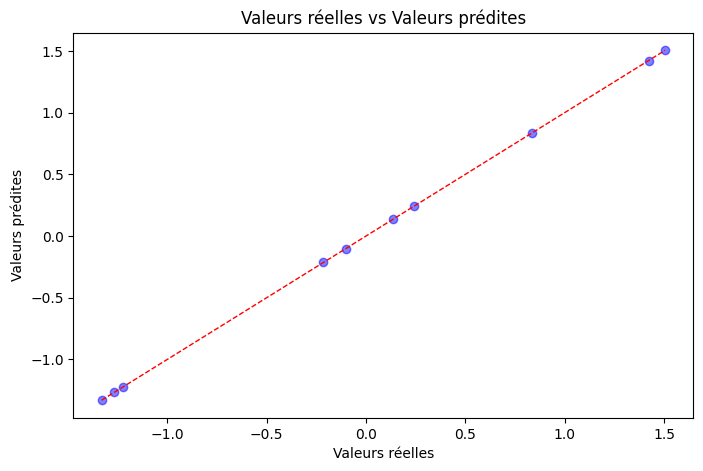

In [41]:
# Prédiction des valeurs avec le modèle
y_pred = reg.predict(X)

# Tracé des valeurs réelles (y) vs valeurs prédites (y_pred)
plt.figure(figsize=(8, 5))
plt.scatter(y, y_pred, alpha=0.5, color='blue')  # Nuage de points
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=1)  # Ligne de référence (y = x)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs réelles vs Valeurs prédites')
plt.show()

#### Commentaires sur les résultats de la régression linéaire
- Energy
- Utilities
- Materials
- Financials
- Industrials
- Health Care
- Real Estate
- Consumer staples

## 6. Commentaires croisés de l'ACP et de la régression linéaire
- Energy
- Utilities
- Materials
- Financials
- Industrials
- Health Care
- Real Estate
- Consumer staples
#### Commentaires généraux
- 
- 
- 

## 7. Propositions pour aller plus loin
- Appliquer le même processus sur d'autres marchés tels que le marché Européen et Japonais pour comparer les résultats
- Tester d'autres ratios fondamentaux pour essayer de gagner en explicabilité
- Mettre en place un alrgotihme de K-means pour classifier par secteur les entreprises en fonction de leurs données fondamentales